[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kshitiz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Dataset Info:
   label                                               text
0      0  Go until jurong point, crazy.. Available only ...
1      0                      Ok lar... Joking wif u oni...
2      1  Free entry in 2 a wkly comp to win FA Cup fina...
3      0  U dun say so early hor... U c already then say...
4      0  Nah I don't think he goes to usf, he lives aro...

Dataset shape: (5572, 2)

Class distribution:
label
0    4825
1     747
Name: count, dtype: int64

Train size: (4457, 3000)
Test size: (1115, 3000)


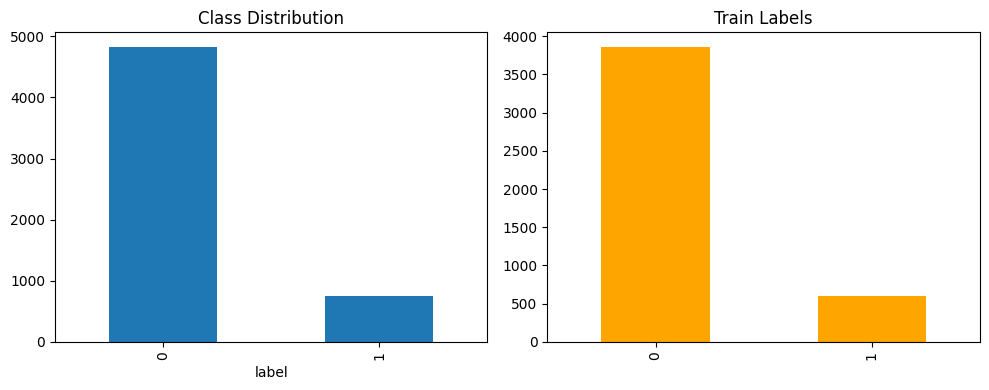


Decision Stump Performance:
Train Accuracy: 0.8838
Test Accuracy: 0.8924

Confusion Matrix (Test):
[[930  36]
 [ 84  65]]


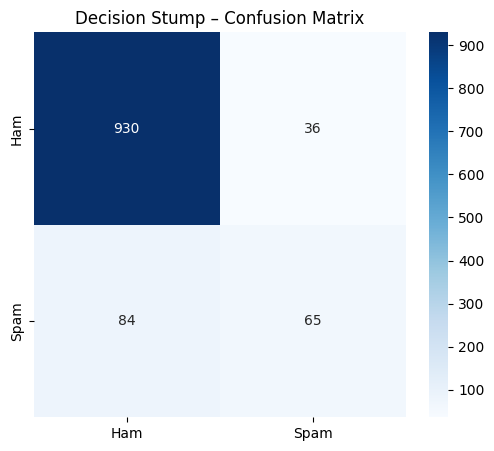


Classification Report:
              precision    recall  f1-score   support

         Ham       0.92      0.96      0.94       966
        Spam       0.64      0.44      0.52       149

    accuracy                           0.89      1115
   macro avg       0.78      0.70      0.73      1115
weighted avg       0.88      0.89      0.88      1115


ROUND 1/15
Weighted Error: 0.116222
Alpha: 1.014353
Misclassified Count: 518

First 10 misclassified indices:
[ 14  42  49  50  59  62  86  93  96 100]

Weights of these samples:
[0.00022437 0.00022437 0.00022437 0.00022437 0.00022437 0.00022437
 0.00022437 0.00022437 0.00022437 0.00022437]

Weight Sum: 1.000000
Max Weight: 0.000233, Min Weight: 0.000084

ROUND 2/15
Weighted Error: 0.077442
Alpha: 1.238813
Misclassified Count: 490

First 10 misclassified indices:
[ 9 15 22 31 39 49 59 66 76 88]

Weights of these samples:
[8.44426929e-05 8.44426929e-05 8.44426929e-05 8.44426929e-05
 8.44426929e-05 2.32857476e-04 2.32857476e-04 8.44426929e-05

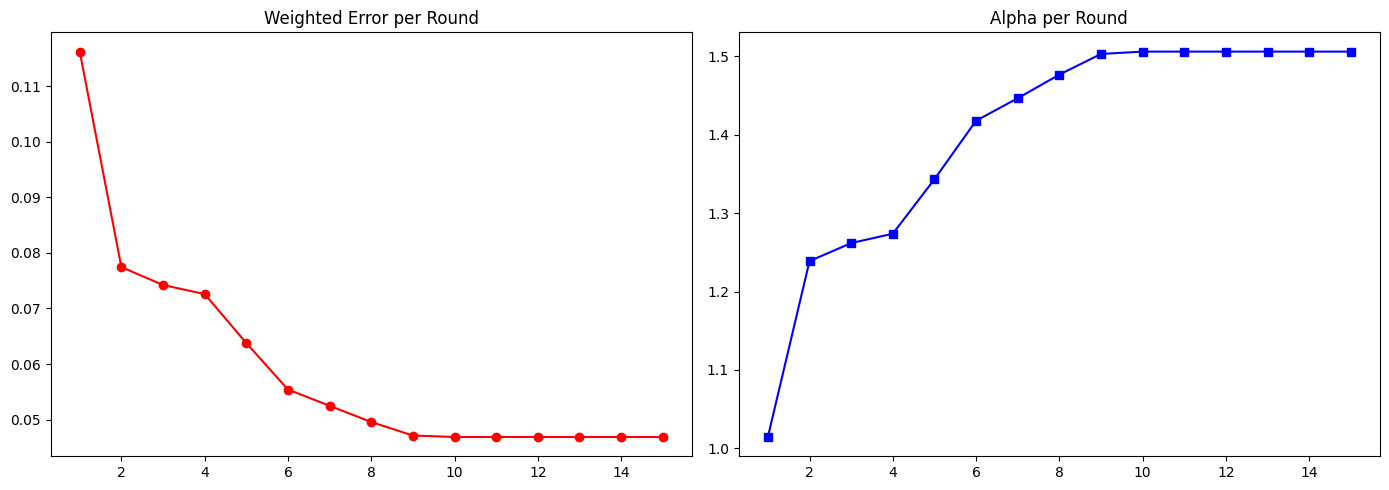

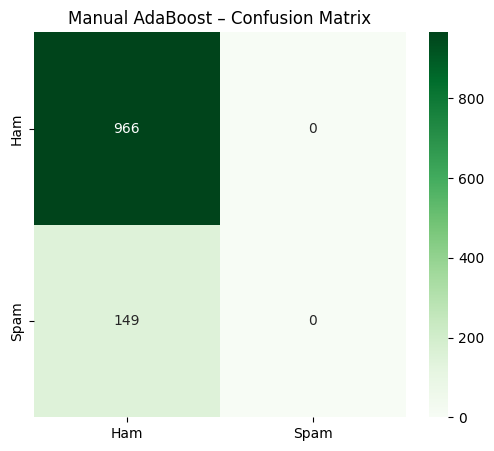

C:\Users\Kshitiz\AppData\Roaming\Python\Python313\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


SKLEARN ADABOOST RESULTS
Train Accuracy: 0.9170
Test Accuracy: 0.9238

Confusion Matrix (Test):
[[966   0]
 [ 85  64]]


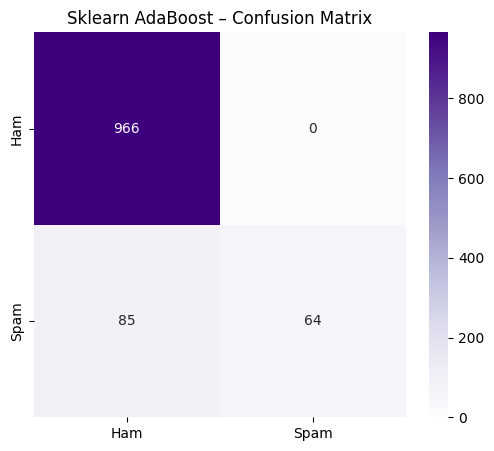


Classification Report:
              precision    recall  f1-score   support

         Ham       0.92      1.00      0.96       966
        Spam       1.00      0.43      0.60       149

    accuracy                           0.92      1115
   macro avg       0.96      0.71      0.78      1115
weighted avg       0.93      0.92      0.91      1115


COMPARISON
Method               Train Acc    Test Acc    
------------------------------------------------------------
Decision Stump       0.8838       0.8924      
Manual AdaBoost      0.8658       0.8664      
Sklearn AdaBoost     0.9170       0.9238      


In [6]:
# Q1: SMS SPAM CLASSIFICATION

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

nltk.download('stopwords')

data_df = pd.read_csv('spam.csv', encoding='latin-1')
data_df = data_df[['v1', 'v2']]
data_df.columns = ['label', 'text']
data_df['label'] = data_df['label'].map({'ham': 0, 'spam': 1})

print("Dataset Info:")
print(data_df.head())
print(f"\nDataset shape: {data_df.shape}")
print("\nClass distribution:")
print(data_df['label'].value_counts())

stop_words = set(stopwords.words('english'))

def clean_text(t):
    t = t.lower()
    t = t.translate(str.maketrans('', '', string.punctuation))
    t = ' '.join([w for w in t.split() if w not in stop_words])
    return t

data_df['processed'] = data_df['text'].apply(clean_text)

vectorizer = TfidfVectorizer(max_features=3000)
X = vectorizer.fit_transform(data_df['processed'])
y = data_df['label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain size: {X_train.shape}")
print(f"Test size: {X_test.shape}")

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
data_df['label'].value_counts().plot(kind='bar')
plt.title("Class Distribution")
plt.subplot(1, 2, 2)
pd.Series(y_train).value_counts().plot(kind='bar', color='orange')
plt.title("Train Labels")
plt.tight_layout()
plt.show()

# Part B – Decision Stump Baseline
base_tree = DecisionTreeClassifier(max_depth=1, random_state=42)
base_tree.fit(X_train, y_train)

pred_train_base = base_tree.predict(X_train)
pred_test_base = base_tree.predict(X_test)

acc_train_base = accuracy_score(y_train, pred_train_base)
acc_test_base = accuracy_score(y_test, pred_test_base)

print("\nDecision Stump Performance:")
print(f"Train Accuracy: {acc_train_base:.4f}")
print(f"Test Accuracy: {acc_test_base:.4f}")
print("\nConfusion Matrix (Test):")
cm_base = confusion_matrix(y_test, pred_test_base)
print(cm_base)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_base, annot=True, cmap='Blues', fmt='d',
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title("Decision Stump – Confusion Matrix")
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, pred_test_base, target_names=['Ham', 'Spam']))

# Part C – Manual AdaBoost
class ManualBoost:
    def __init__(self, rounds=15):
        self.rounds = rounds
        self.alpha_vals = []
        self.models = []
        self.err_vals = []
        
    def fit(self, X, y):
        n = X.shape[0]
        w = np.ones(n) / n
        
        for i in range(self.rounds):
            print("\n" + "="*60)
            print(f"ROUND {i+1}/{self.rounds}")
            print("="*60)

            stump = DecisionTreeClassifier(max_depth=1, random_state=42)
            stump.fit(X, y, sample_weight=w)
            pred = stump.predict(X)

            mis = (pred != y)
            err = np.sum(w[mis]) / np.sum(w)
            err = np.clip(err, 1e-10, 1 - 1e-10)

            alpha = 0.5 * np.log((1 - err) / err)

            print(f"Weighted Error: {err:.6f}")
            print(f"Alpha: {alpha:.6f}")
            print(f"Misclassified Count: {mis.sum()}")
            mis_idx = np.where(mis)[0]
            print("\nFirst 10 misclassified indices:")
            print(mis_idx[:10])
            print("\nWeights of these samples:")
            print(w[mis_idx[:10]])

            w = w * np.exp(-alpha * y * pred)
            w = w / np.sum(w)

            print(f"\nWeight Sum: {np.sum(w):.6f}")
            print(f"Max Weight: {np.max(w):.6f}, Min Weight: {np.min(w):.6f}")

            self.models.append(stump)
            self.alpha_vals.append(alpha)
            self.err_vals.append(err)
    
    def predict(self, X):
        preds = np.array([m.predict(X) for m in self.models])
        preds = 2 * preds - 1
        score = np.dot(self.alpha_vals, preds)
        return (score > 0).astype(int)

manual_model = ManualBoost(rounds=15)
manual_model.fit(X_train, y_train)

train_pred_manual = manual_model.predict(X_train)
test_pred_manual = manual_model.predict(X_test)

acc_manual_train = accuracy_score(y_train, train_pred_manual)
acc_manual_test = accuracy_score(y_test, test_pred_manual)

print("\n" + "="*60)
print("MANUAL BOOST RESULTS")
print("="*60)
print(f"Train Accuracy: {acc_manual_train:.4f}")
print(f"Test Accuracy: {acc_manual_test:.4f}")
print("\nConfusion Matrix (Test):")
cm_manual = confusion_matrix(y_test, test_pred_manual)
print(cm_manual)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot(range(1, 16), manual_model.err_vals, marker='o', color='red')
ax[0].set_title("Weighted Error per Round")
ax[1].plot(range(1, 16), manual_model.alpha_vals, marker='s', color='blue')
ax[1].set_title("Alpha per Round")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
sns.heatmap(cm_manual, annot=True, cmap='Greens', fmt='d',
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title("Manual AdaBoost – Confusion Matrix")
plt.show()

# Part D – Sklearn AdaBoost
sk_ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=100,
    learning_rate=0.6,
    random_state=42,
    algorithm='SAMME'
)

sk_ada.fit(X_train, y_train)

train_pred_sk = sk_ada.predict(X_train)
test_pred_sk = sk_ada.predict(X_test)

acc_train_sk = accuracy_score(y_train, train_pred_sk)
acc_test_sk = accuracy_score(y_test, test_pred_sk)

print("="*60)
print("SKLEARN ADABOOST RESULTS")
print("="*60)
print(f"Train Accuracy: {acc_train_sk:.4f}")
print(f"Test Accuracy: {acc_test_sk:.4f}")
print("\nConfusion Matrix (Test):")
cm_sk = confusion_matrix(y_test, test_pred_sk)
print(cm_sk)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_sk, annot=True, cmap='Purples', fmt='d',
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title("Sklearn AdaBoost – Confusion Matrix")
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, test_pred_sk, target_names=['Ham', 'Spam']))

print("\n" + "="*60)
print("COMPARISON")
print("="*60)
print(f"{'Method':<20} {'Train Acc':<12} {'Test Acc':<12}")
print("-"*60)
print(f"{'Decision Stump':<20} {acc_train_base:<12.4f} {acc_test_base:<12.4f}")
print(f"{'Manual AdaBoost':<20} {acc_manual_train:<12.4f} {acc_manual_test:<12.4f}")
print(f"{'Sklearn AdaBoost':<20} {acc_train_sk:<12.4f} {acc_test_sk:<12.4f}")


Dataset Info:
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   52    1   0       125   212    0        1      168      0      1.0      2   
1   53    1   0       140   203    1        0      155      1      3.1      0   
2   70    1   0       145   174    0        1      125      1      2.6      0   
3   61    1   0       148   203    0        1      161      0      0.0      2   
4   62    0   0       138   294    1        1      106      0      1.9      1   

   ca  thal  target  
0   2     3       0  
1   0     3       0  
2   0     3       0  
3   1     3       0  
4   3     2       0  

Dataset shape: (1025, 14)

Missing values:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

Train set: (820, 13)
Test set: (205, 13)

Training Accuracy: 0.7695
Test Accuracy: 0.7220

Confusion Matrix (Test

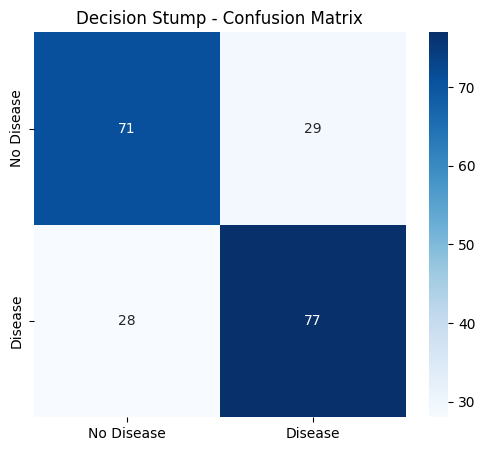


Classification Report:
              precision    recall  f1-score   support

  No Disease       0.72      0.71      0.71       100
     Disease       0.73      0.73      0.73       105

    accuracy                           0.72       205
   macro avg       0.72      0.72      0.72       205
weighted avg       0.72      0.72      0.72       205

TRAINING ADABOOST WITH DIFFERENT HYPERPARAMETERS
LR=0.1, n_estimators=  5 -> Test Accuracy: 0.7220
LR=0.1, n_estimators= 10 -> Test Accuracy: 0.7756
LR=0.1, n_estimators= 25 -> Test Accuracy: 0.8439
LR=0.1, n_estimators= 50 -> Test Accuracy: 0.8293


C:\Users\Kshitiz\AppData\Roaming\Python\Python313\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
C:\Users\Kshitiz\AppData\Roaming\Python\Python313\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
C:\Users\Kshitiz\AppData\Roaming\Python\Python313\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
C:\Users\Kshitiz\AppData\Roaming\Python\Python313\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
C:\Users\Kshitiz\AppData\Roaming\Python\Pyth

LR=0.1, n_estimators=100 -> Test Accuracy: 0.8780

LR=0.5, n_estimators=  5 -> Test Accuracy: 0.8195
LR=0.5, n_estimators= 10 -> Test Accuracy: 0.8537
LR=0.5, n_estimators= 25 -> Test Accuracy: 0.8780
LR=0.5, n_estimators= 50 -> Test Accuracy: 0.8732


C:\Users\Kshitiz\AppData\Roaming\Python\Python313\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
C:\Users\Kshitiz\AppData\Roaming\Python\Python313\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
C:\Users\Kshitiz\AppData\Roaming\Python\Python313\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
C:\Users\Kshitiz\AppData\Roaming\Python\Python313\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
C:\Users\Kshitiz\AppData\Roaming\Python\Pyth

LR=0.5, n_estimators=100 -> Test Accuracy: 0.8829

LR=1.0, n_estimators=  5 -> Test Accuracy: 0.8049
LR=1.0, n_estimators= 10 -> Test Accuracy: 0.8780
LR=1.0, n_estimators= 25 -> Test Accuracy: 0.8634
LR=1.0, n_estimators= 50 -> Test Accuracy: 0.8634


C:\Users\Kshitiz\AppData\Roaming\Python\Python313\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
C:\Users\Kshitiz\AppData\Roaming\Python\Python313\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
C:\Users\Kshitiz\AppData\Roaming\Python\Python313\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
C:\Users\Kshitiz\AppData\Roaming\Python\Python313\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
C:\Users\Kshitiz\AppData\Roaming\Python\Pyth

LR=1.0, n_estimators=100 -> Test Accuracy: 0.8878



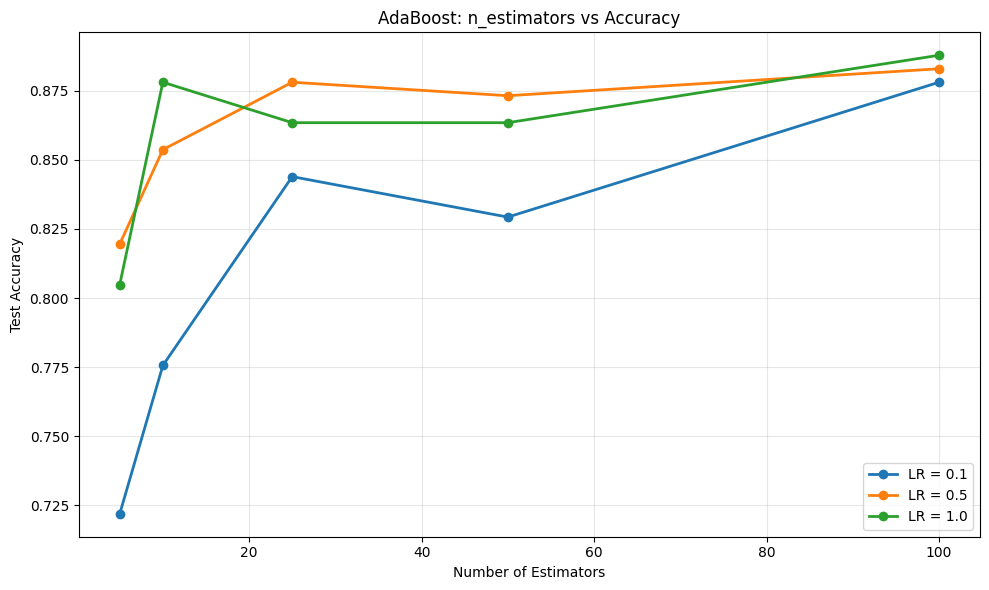

C:\Users\Kshitiz\AppData\Roaming\Python\Python313\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
C:\Users\Kshitiz\AppData\Roaming\Python\Python313\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
C:\Users\Kshitiz\AppData\Roaming\Python\Python313\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
C:\Users\Kshitiz\AppData\Roaming\Python\Python313\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
C:\Users\Kshitiz\AppData\Roaming\Python\Pyth

BEST CONFIGURATION
Learning Rate: 1.0
Number of Estimators: 100
Test Accuracy: 0.8878


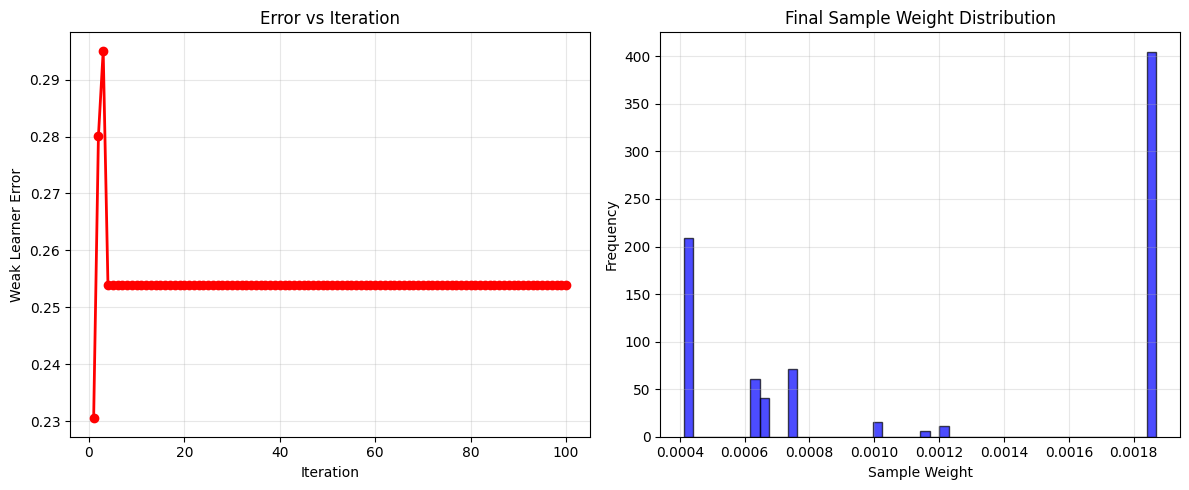


Top 10 samples with highest weights:
Index      Weight         
-------------------------
30         0.001870       
29         0.001870       
28         0.001870       
27         0.001870       
22         0.001870       
20         0.001870       
19         0.001870       
818        0.001870       
1          0.001870       
0          0.001870       

Top 10 Most Important Features:
Rank   Feature                   Importance  
--------------------------------------------------
1      chol                      0.182314    
2      oldpeak                   0.177989    
3      thalach                   0.158805    
4      age                       0.096686    
5      trestbps                  0.095465    
6      ca                        0.090985    
7      cp                        0.064592    
8      thal                      0.045515    
9      sex                       0.042590    
10     slope                     0.025653    


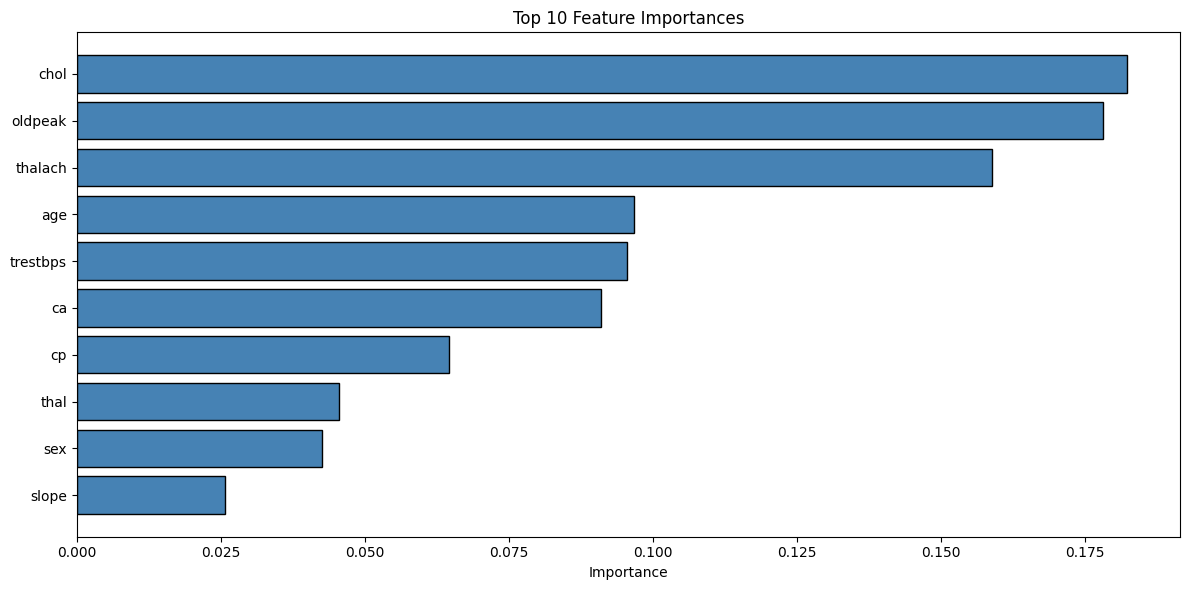

In [1]:
# Q2: HEART DISEASE PREDICTION

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

df = pd.read_csv('heart.csv')

print("Dataset Info:")
print(df.head())
print(f"\nDataset shape: {df.shape}")
print("\nMissing values:")
print(df.isnull().sum())

df = df.dropna()

X = df.drop('target', axis=1)
y = (df['target'] > 0).astype(int)

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_std, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

weak_tree = DecisionTreeClassifier(max_depth=1, random_state=42)
weak_tree.fit(X_train, y_train)

train_pred = weak_tree.predict(X_train)
test_pred = weak_tree.predict(X_test)

acc_train = accuracy_score(y_train, train_pred)
acc_test = accuracy_score(y_test, test_pred)

print(f"\nTraining Accuracy: {acc_train:.4f}")
print(f"Test Accuracy: {acc_test:.4f}")
print("\nConfusion Matrix (Test Set):")
cm = confusion_matrix(y_test, test_pred)
print(cm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'])
plt.title("Decision Stump - Confusion Matrix")
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, test_pred,
                            target_names=['No Disease', 'Disease']))

n_list = [5, 10, 25, 50, 100]
lr_list = [0.1, 0.5, 1.0]

records = []

print("="*60)
print("TRAINING ADABOOST WITH DIFFERENT HYPERPARAMETERS")
print("="*60)

for lr in lr_list:
    row_accs = []
    for n_est in n_list:
        model = AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=1),
            n_estimators=n_est,
            learning_rate=lr,
            random_state=42,
            algorithm='SAMME'
        )
        model.fit(X_train, y_train)
        acc = accuracy_score(y_test, model.predict(X_test))
        row_accs.append(acc)
        print(f"LR={lr:.1f}, n_estimators={n_est:3d} -> Test Accuracy: {acc:.4f}")
    records.append({"lr": lr, "accs": row_accs})
    print()

plt.figure(figsize=(10, 6))
for item in records:
    plt.plot(n_list, item["accs"], marker='o', linewidth=2,
             label=f"LR = {item['lr']}")
plt.xlabel("Number of Estimators")
plt.ylabel("Test Accuracy")
plt.title("AdaBoost: n_estimators vs Accuracy")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

best_acc = 0
best_cfg = {}

for lr in lr_list:
    for n_est in n_list:
        temp = AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=1),
            n_estimators=n_est,
            learning_rate=lr,
            random_state=42,
            algorithm='SAMME'
        )
        temp.fit(X_train, y_train)
        score = accuracy_score(y_test, temp.predict(X_test))
        if score > best_acc:
            best_acc = score
            best_cfg = {
                'lr': lr,
                'n_est': n_est,
                'model': temp,
                'acc': score
            }

print("="*60)
print("BEST CONFIGURATION")
print("="*60)
print(f"Learning Rate: {best_cfg['lr']}")
print(f"Number of Estimators: {best_cfg['n_est']}")
print(f"Test Accuracy: {best_cfg['acc']:.4f}")

chosen_model = best_cfg['model']

class BoostMonitor:
    def __init__(self, rounds, lr):
        self.rounds = rounds
        self.lr = lr
        self.errs = []
        self.alphas = []
        self.weight_history = []

    def fit(self, X, y):
        n = len(y)
        w = np.ones(n) / n

        for i in range(self.rounds):
            stump = DecisionTreeClassifier(max_depth=1, random_state=99 + i)
            stump.fit(X, y, sample_weight=w)
            preds = stump.predict(X)

            incorrect = preds != y
            e = np.sum(w[incorrect]) / np.sum(w)
            e = np.clip(e, 1e-10, 1 - 1e-10)

            a = self.lr * 0.5 * np.log((1 - e) / e)

            self.errs.append(e)
            self.alphas.append(a)
            self.weight_history.append(w.copy())

            w = w * np.exp(-a * y * preds)
            w = w / np.sum(w)

        self.final_weights = w
        return self

monitor = BoostMonitor(best_cfg['n_est'], best_cfg['lr'])
monitor.fit(X_train, y_train)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(monitor.errs) + 1), monitor.errs, marker='o',
         linewidth=2, color='red')
plt.xlabel("Iteration")
plt.ylabel("Weak Learner Error")
plt.title("Error vs Iteration")
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(monitor.final_weights, bins=50, color='blue', edgecolor='black', alpha=0.7)
plt.xlabel("Sample Weight")
plt.ylabel("Frequency")
plt.title("Final Sample Weight Distribution")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

k = 10
idxs = np.argsort(monitor.final_weights.values)[-k:]
vals = monitor.final_weights.iloc[idxs]

print(f"\nTop {k} samples with highest weights:")
print(f"{'Index':<10} {'Weight':<15}")
print("-" * 25)
for i, w in zip(idxs, vals):
    print(f"{i:<10} {w:<15.6f}")

importances = chosen_model.feature_importances_
cols = X.columns

order = np.argsort(importances)[::-1]
k2 = min(10, len(cols))

print(f"\nTop {k2} Most Important Features:")
print(f"{'Rank':<6} {'Feature':<25} {'Importance':<12}")
print("-" * 50)
for i in range(k2):
    j = order[i]
    print(f"{i+1:<6} {cols[j]:<25} {importances[j]:<12.6f}")

plt.figure(figsize=(12, 6))
top_features = [cols[i] for i in order[:k2]]
top_vals = [importances[i] for i in order[:k2]]

plt.barh(range(k2), top_vals, color='steelblue', edgecolor='black')
plt.yticks(range(k2), top_features)
plt.xlabel("Importance")
plt.title("Top 10 Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Dataset shape: (5000, 6)

First few rows:
   user_id    activity  timestamp         x         y          z
0       29  Downstairs          0 -0.772645 -0.609336   7.905154
1       15     Sitting          1 -4.410589  1.241002   9.291691
2        8     Walking          2  2.779528 -5.458809   7.489008
3       21     Walking          3 -2.690419  0.010411   4.659705
4       19  Downstairs          4 -2.006878 -0.919211  11.854009

Activity distribution:
activity
Jogging       895
Walking       882
Upstairs      834
Downstairs    803
Sitting       796
Standing      790
Name: count, dtype: int64

Label distribution:
label
0    3271
1    1729
Name: count, dtype: int64

Train set size: (3500, 3)
Test set size: (1500, 3)


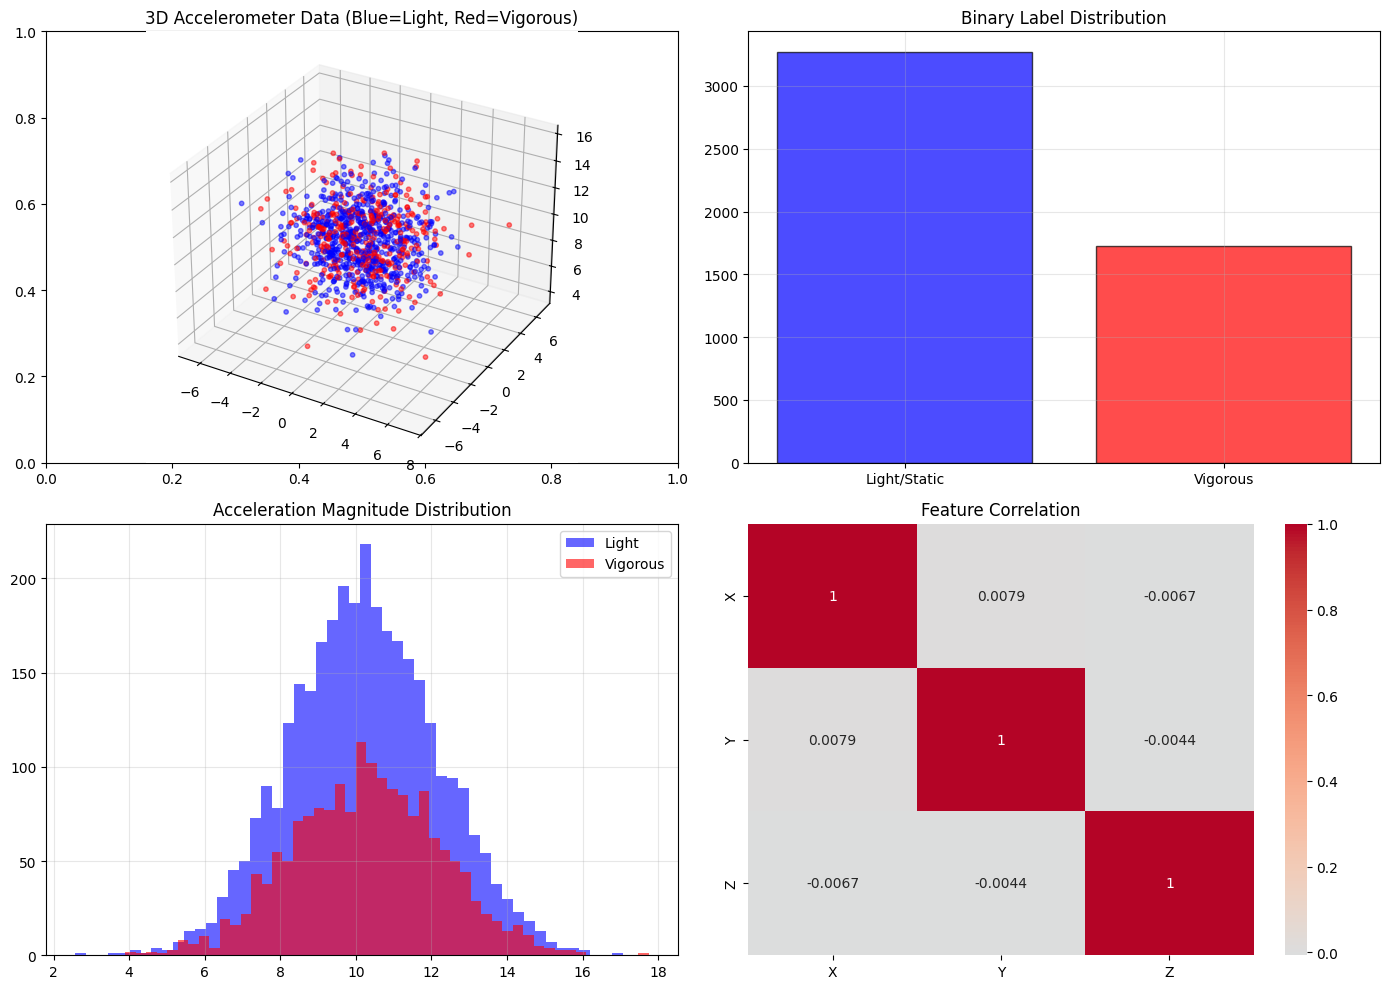


Train Accuracy: 0.6543
Test Accuracy: 0.6540

Confusion Matrix (Test Set):
[[981   0]
 [519   0]]


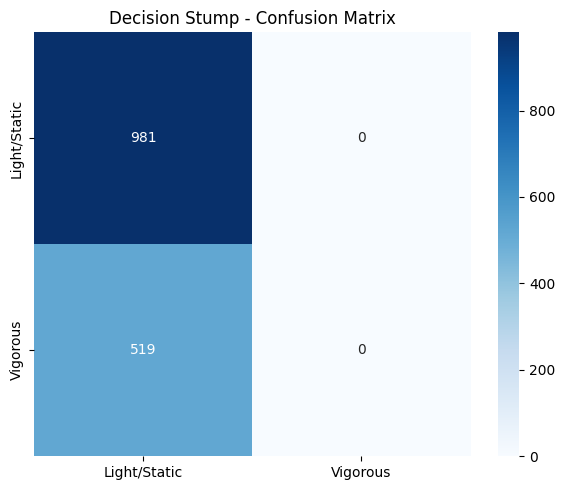


Classification Report:
              precision    recall  f1-score   support

Light/Static       0.65      1.00      0.79       981
    Vigorous       0.00      0.00      0.00       519

    accuracy                           0.65      1500
   macro avg       0.33      0.50      0.40      1500
weighted avg       0.43      0.65      0.52      1500


ITERATION 1/20
Weighted Error: 0.345714
Alpha: 0.318966
Misclassified samples: 1210

First 10 indices:
[ 5 10 19 22 24 25 28 29 30 38]

Weights of these samples:
  Sample 5: 0.00028571
  Sample 10: 0.00028571
  Sample 19: 0.00028571
  Sample 22: 0.00028571
  Sample 24: 0.00028571
  Sample 25: 0.00028571
  Sample 28: 0.00028571
  Sample 29: 0.00028571
  Sample 30: 0.00028571
  Sample 38: 0.00028571

After update:
  Sum: 1.000000
  Max: 0.00028571
  Min: 0.00028571

ITERATION 2/20
Weighted Error: 0.345714
Alpha: 0.318966
Misclassified samples: 1210

First 10 indices:
[ 5 10 19 22 24 25 28 29 30 38]

Weights of these samples:
  Sample 5: 0.000

C:\Users\Kshitiz\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Kshitiz\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Kshitiz\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

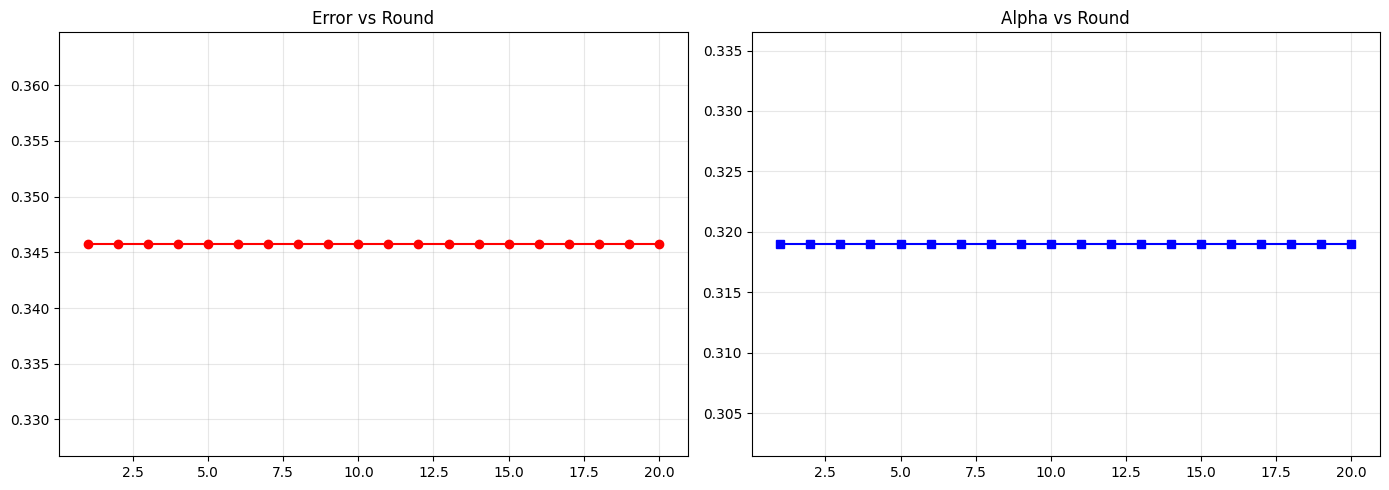

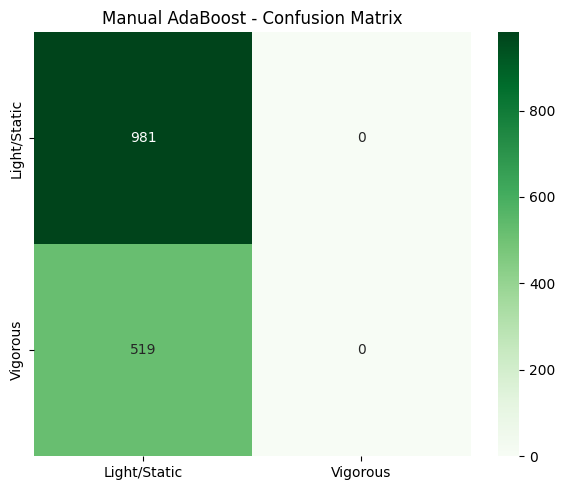


Classification Report:
              precision    recall  f1-score   support

Light/Static       0.65      1.00      0.79       981
    Vigorous       0.00      0.00      0.00       519

    accuracy                           0.65      1500
   macro avg       0.33      0.50      0.40      1500
weighted avg       0.43      0.65      0.52      1500



C:\Users\Kshitiz\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Kshitiz\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Kshitiz\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c


Train Accuracy: 0.6546
Test Accuracy: 0.6540

Confusion Matrix (Test Set):
[[981   0]
 [519   0]]


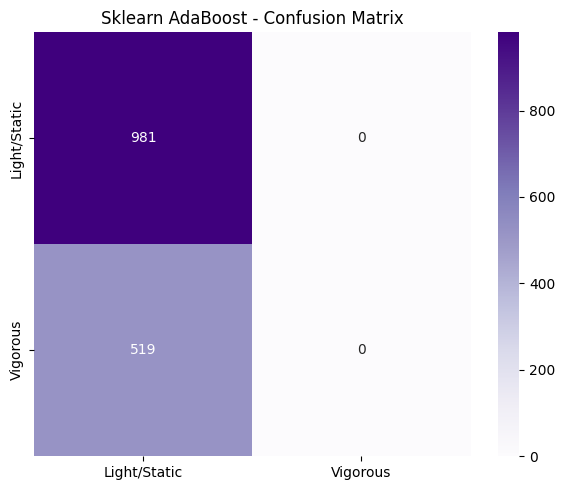


Classification Report:
              precision    recall  f1-score   support

Light/Static       0.65      1.00      0.79       981
    Vigorous       0.00      0.00      0.00       519

    accuracy                           0.65      1500
   macro avg       0.33      0.50      0.40      1500
weighted avg       0.43      0.65      0.52      1500


COMPARISON
Method                    Train Acc    Test Acc    
----------------------------------------------------------------------
Decision Stump            0.6543       0.6540      
Manual AdaBoost (T=20)    0.6543       0.6540      
Sklearn AdaBoost (T=100)  0.6546       0.6540      

Feature Importance:
X-axis         : 0.2868
Y-axis         : 0.5953
Z-axis         : 0.1180


C:\Users\Kshitiz\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Kshitiz\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Kshitiz\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

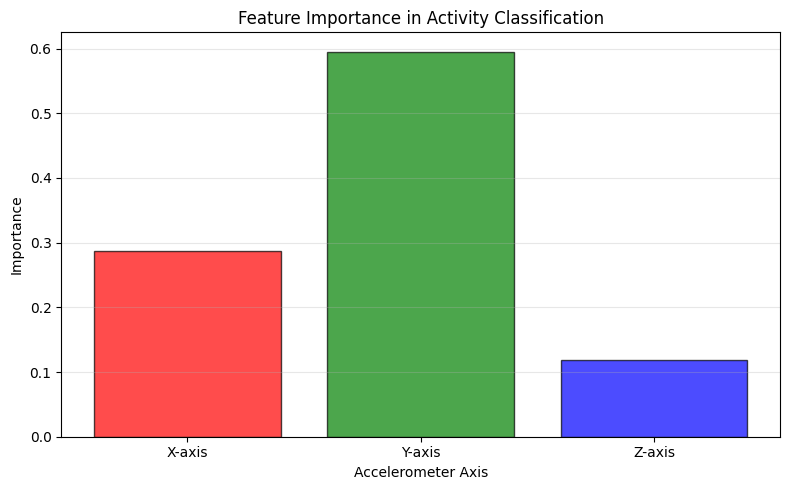

In [8]:
# Q3: WISDM MOTION SENSOR ACTIVITY CLASSIFICATION

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

cols = ['user_id', 'activity', 'timestamp', 'x', 'y', 'z']

try:
    raw = pd.read_csv(
        "WISDM_ar_v1.1_raw.txt",
        header=None,
        names=cols,
        on_bad_lines='skip'
    )
    if raw['z'].dtype == object:
        raw['z'] = raw['z'].str.replace(';', '')
        raw['z'] = pd.to_numeric(raw['z'], errors='coerce')
except:
    np.random.seed(42)
    total = 5000
    acts = ['Walking', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Downstairs']
    raw = pd.DataFrame({
        'user_id': np.random.randint(1, 36, total),
        'activity': np.random.choice(acts, total),
        'timestamp': np.arange(total),
        'x': np.random.randn(total) * 2,
        'y': np.random.randn(total) * 2,
        'z': np.random.randn(total) * 2 + 9.8
    })

print(f"Dataset shape: {raw.shape}")
print("\nFirst few rows:")
print(raw.head())
print("\nActivity distribution:")
print(raw['activity'].value_counts())

raw = raw.dropna()

def map_label(act):
    return 1 if act in ["Jogging", "Upstairs"] else 0

raw["label"] = raw["activity"].apply(map_label)

print("\nLabel distribution:")
print(raw["label"].value_counts())

X = raw[["x", "y", "z"]].values
y = raw["label"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\nTrain set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

ax = fig.add_subplot(2, 2, 1, projection="3d")
size = min(1000, len(X))
cols3 = ["red" if lab == 1 else "blue" for lab in y[:size]]
ax.scatter(
    X[:size, 0],
    X[:size, 1],
    X[:size, 2],
    c=cols3,
    alpha=0.5,
    s=10
)
ax.set_title("3D Accelerometer Data (Blue=Light, Red=Vigorous)")

axes[0, 1].bar(
    ["Light/Static", "Vigorous"],
    raw["label"].value_counts().sort_index().values,
    color=["blue", "red"],
    alpha=0.7,
    edgecolor="black"
)
axes[0, 1].set_title("Binary Label Distribution")
axes[0, 1].grid(True, alpha=0.3)

mag = np.sqrt(X[:, 0]**2 + X[:, 1]**2 + X[:, 2]**2)
axes[1, 0].hist(mag[y == 0], bins=50, alpha=0.6, label="Light", color="blue")
axes[1, 0].hist(mag[y == 1], bins=50, alpha=0.6, label="Vigorous", color="red")
axes[1, 0].set_title("Acceleration Magnitude Distribution")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].clear()
corr_df = pd.DataFrame(X, columns=["X", "Y", "Z"])
sns.heatmap(corr_df.corr(), annot=True, cmap="coolwarm", center=0, ax=axes[1, 1])
axes[1, 1].set_title("Feature Correlation")

plt.tight_layout()
plt.show()

weak = DecisionTreeClassifier(max_depth=1, random_state=42)
weak.fit(X_train, y_train)

train_pred_w = weak.predict(X_train)
test_pred_w = weak.predict(X_test)

acc_train_w = accuracy_score(y_train, train_pred_w)
acc_test_w = accuracy_score(y_test, test_pred_w)

print(f"\nTrain Accuracy: {acc_train_w:.4f}")
print(f"Test Accuracy: {acc_test_w:.4f}")
print("\nConfusion Matrix (Test Set):")
cm_w = confusion_matrix(y_test, test_pred_w)
print(cm_w)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_w, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Light/Static', 'Vigorous'],
            yticklabels=['Light/Static', 'Vigorous'])
plt.title("Decision Stump - Confusion Matrix")
plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, test_pred_w,
                            target_names=['Light/Static', 'Vigorous']))

class ManualMotionBoost:
    def __init__(self, rounds=20):
        self.rounds = rounds
        self.a_vals = []
        self.models = []
        self.err_vals = []
        
    def fit(self, X, y):
        n = len(y)
        w = np.ones(n) / n
        
        for i in range(self.rounds):
            print("\n" + "="*60)
            print(f"ITERATION {i+1}/{self.rounds}")
            print("="*60)
            
            stump = DecisionTreeClassifier(max_depth=1, random_state=100 + i)
            stump.fit(X, y, sample_weight=w)
            pred = stump.predict(X)
            
            mis = pred != y
            idxs = np.where(mis)[0]
            
            err = np.sum(w[mis]) / np.sum(w)
            err = np.clip(err, 1e-10, 1 - 1e-10)
            
            a = 0.5 * np.log((1 - err) / err)
            
            print(f"Weighted Error: {err:.6f}")
            print(f"Alpha: {a:.6f}")
            print(f"Misclassified samples: {len(idxs)}")
            print("\nFirst 10 indices:")
            print(idxs[:10])
            print("\nWeights of these samples:")
            for idx in idxs[:10]:
                print(f"  Sample {idx}: {w[idx]:.8f}")
            
            w = w * np.exp(-a * y * pred)
            w = w / np.sum(w)
            
            print("\nAfter update:")
            print(f"  Sum: {np.sum(w):.6f}")
            print(f"  Max: {np.max(w):.8f}")
            print(f"  Min: {np.min(w):.8f}")
            
            self.models.append(stump)
            self.a_vals.append(a)
            self.err_vals.append(err)
        
        return self
    
    def predict(self, X):
        preds = np.array([m.predict(X) for m in self.models])
        preds = 2 * preds - 1
        weighted = np.dot(self.a_vals, preds)
        return (weighted > 0).astype(int)

manual_model = ManualMotionBoost(rounds=20)
manual_model.fit(X_train, y_train)

train_pred_m = manual_model.predict(X_train)
test_pred_m = manual_model.predict(X_test)

acc_train_m = accuracy_score(y_train, train_pred_m)
acc_test_m = accuracy_score(y_test, test_pred_m)

print("\n" + "="*60)
print("MANUAL ADABOOST RESULTS")
print("="*60)
print(f"Train Accuracy: {acc_train_m:.4f}")
print(f"Test Accuracy: {acc_test_m:.4f}")
print("\nConfusion Matrix (Test Set):")
cm_m = confusion_matrix(y_test, test_pred_m)
print(cm_m)

fig, axx = plt.subplots(1, 2, figsize=(14, 5))
axx[0].plot(range(1, 21), manual_model.err_vals, marker='o', color='red')
axx[0].set_title("Error vs Round")
axx[0].grid(True, alpha=0.3)
axx[1].plot(range(1, 21), manual_model.a_vals, marker='s', color='blue')
axx[1].set_title("Alpha vs Round")
axx[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
sns.heatmap(cm_m, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Light/Static', 'Vigorous'],
            yticklabels=['Light/Static', 'Vigorous'])
plt.title("Manual AdaBoost - Confusion Matrix")
plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, test_pred_m,
                            target_names=['Light/Static', 'Vigorous']))

sk_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=100,
    learning_rate=1.0,
    random_state=42,
    algorithm='SAMME'
)

sk_model.fit(X_train, y_train)

train_pred_s = sk_model.predict(X_train)
test_pred_s = sk_model.predict(X_test)

acc_train_s = accuracy_score(y_train, train_pred_s)
acc_test_s = accuracy_score(y_test, test_pred_s)

print(f"\nTrain Accuracy: {acc_train_s:.4f}")
print(f"Test Accuracy: {acc_test_s:.4f}")
print("\nConfusion Matrix (Test Set):")
cm_s = confusion_matrix(y_test, test_pred_s)
print(cm_s)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_s, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Light/Static', 'Vigorous'],
            yticklabels=['Light/Static', 'Vigorous'])
plt.title("Sklearn AdaBoost - Confusion Matrix")
plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, test_pred_s,
                            target_names=['Light/Static', 'Vigorous']))

print("\n" + "="*60)
print("COMPARISON")
print("="*60)
print(f"{'Method':<25} {'Train Acc':<12} {'Test Acc':<12}")
print("-"*70)
print(f"{'Decision Stump':<25} {acc_train_w:<12.4f} {acc_test_w:<12.4f}")
print(f"{'Manual AdaBoost (T=20)':<25} {acc_train_m:<12.4f} {acc_test_m:<12.4f}")
print(f"{'Sklearn AdaBoost (T=100)':<25} {acc_train_s:<12.4f} {acc_test_s:<12.4f}")

axis_names = ["X-axis", "Y-axis", "Z-axis"]
importances = sk_model.feature_importances_

print("\nFeature Importance:")
for axis, imp in zip(axis_names, importances):
    print(f"{axis:<15}: {imp:.4f}")

plt.figure(figsize=(8, 5))
plt.bar(axis_names, importances, color=["red", "green", "blue"],
        alpha=0.7, edgecolor="black")
plt.ylabel("Importance")
plt.xlabel("Accelerometer Axis")
plt.title("Feature Importance in Activity Classification")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()
